<a href="https://colab.research.google.com/github/RashiMakharia/Bioinformatics-Pipeline/blob/main/Bioinformatics_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -----------------------------
# Block 1: Setup & Imports
# -----------------------------
%pip install biopython
from pathlib import Path
import requests
from Bio import SeqIO, Entrez, SeqUtils, pairwise2
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.PDB import PDBParser
import matplotlib.pyplot as plt

# Set email for NCBI Entrez (required by NCBI policy)
Entrez.email = "rashimakharia21@gmail.com"

# IDs for this project
PDB_ID = "1NQL"
NUCL_ACCESSION = "NM_000321"

# Output directory
OUTDIR = Path("pipeline_outputs")
OUTDIR.mkdir(parents=True, exist_ok=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 46.5 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [ ]:
# -----------------------------
# Block 2: Fetch and Parse PDB
# -----------------------------
def fetch_pdb(pdb_id: str, outdir: Path):
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    r = requests.get(url)
    pdb_path = outdir / f"{pdb_id}.pdb"
    pdb_path.write_text(r.text)
    return pdb_path

def parse_pdb_sequences(pdb_path: Path):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(pdb_path.stem, str(pdb_path))
    seqs = []
    for model in structure:
        for chain in model:
            residues = [res for res in chain]
            aa_seq = ''.join(SeqUtils.seq1(res.get_resname()) for res in residues if SeqUtils.seq1(res.get_resname()) != 'X')
            if aa_seq:
                seqs.append(SeqRecord(Seq(aa_seq), id=f"{pdb_path.stem}_{chain.id}", description=f"chain {chain.id}"))
    return seqs

# Run
pdb_path = fetch_pdb(PDB_ID, OUTDIR)
pdb_seqs = parse_pdb_sequences(pdb_path)

# Save sequences
SeqIO.write(pdb_seqs, OUTDIR / f"{PDB_ID}_chains.fasta", "fasta")

print(f"Extracted {len(pdb_seqs)} protein chains from PDB {PDB_ID}")


Extracted 2 protein chains from PDB 1NQL


In [ ]:
# -----------------------------
# Block 3: Fetch Nucleotide Sequence
# -----------------------------
def fetch_nucleotide(accession: str, outdir: Path):
    handle = Entrez.efetch(db="nucleotide", id=accession, rettype="gb", retmode="text")
    text = handle.read()
    handle.close()
    gb_path = outdir / f"{accession}.gb"
    gb_path.write_text(text)
    return gb_path

def parse_genbank(gb_path: Path):
    return SeqIO.read(str(gb_path), "genbank")

# Run
gb_path = fetch_nucleotide(NUCL_ACCESSION, OUTDIR)
nucl_record = parse_genbank(gb_path)

print(f"Fetched nucleotide {NUCL_ACCESSION}, length = {len(nucl_record.seq)} bp")


Fetched nucleotide NM_000321, length = 4768 bp


In [ ]:
# -----------------------------
# Block 4: Sequence Analysis
# -----------------------------
from collections import Counter
# GC Content
gc_percent = SeqUtils.gc_fraction(nucl_record.seq) * 100
print(f"GC content: {gc_percent:.2f}%")
# ORF finder (naive)
def find_orfs(seq, min_len=50):
    seq = str(seq).upper()
    orfs = []
    stops = {"TAA","TAG","TGA"}
    for frame in range(3):
        i = frame
        while i < len(seq)-2:
            if seq[i:i+3] == "ATG":
                for j in range(i+3, len(seq)-2, 3):
                    if seq[j:j+3] in stops:
                        prot = Seq(seq[i:j+3]).translate(to_stop=True)
                        if len(prot) >= min_len:
                            orfs.append((i+1, j+3, prot))
                        break
            i += 3
    return orfs

orfs = find_orfs(nucl_record.seq, 50)
print(f"Found {len(orfs)} ORFs longer than 50 aa")

# Codon usage
codons = [str(nucl_record.seq[i:i+3]) for i in range(0,len(nucl_record.seq)-2,3)]
codon_counts = Counter(codons)
print("Top codons:", codon_counts.most_common(5))


GC content: 37.08%
Found 25 ORFs longer than 50 aa
Top codons: [('AAA', 91), ('TTT', 66), ('GAA', 59), ('AAT', 48), ('TTA', 47)]


In [ ]:
# -----------------------------
# Block 5: DNA → Protein
# -----------------------------
# Trim the sequence to be a multiple of 3 before translation
trimmed_seq = nucl_record.seq[:len(nucl_record.seq) // 3 * 3]
translated_protein = trimmed_seq.translate(to_stop=True)
print(f"Translated protein length: {len(translated_protein)} aa")

Translated protein length: 20 aa


In [ ]:
# -----------------------------
# Block 6: Pairwise Alignment
# -----------------------------
from Bio import pairwise2

if pdb_seqs:
    aln = pairwise2.align.globalxx(translated_protein, pdb_seqs[0].seq, one_alignment_only=True)[0]
    print("Alignment Score:", aln.score)
    print(aln.seqA[:100], "...")
    print(aln.seqB[:100], "...")


Alignment Score: 20.0
--------S----------------------C-------------R-------------AG---------E-----------G--------A----S--- ...
EKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALAVLSNYD ...


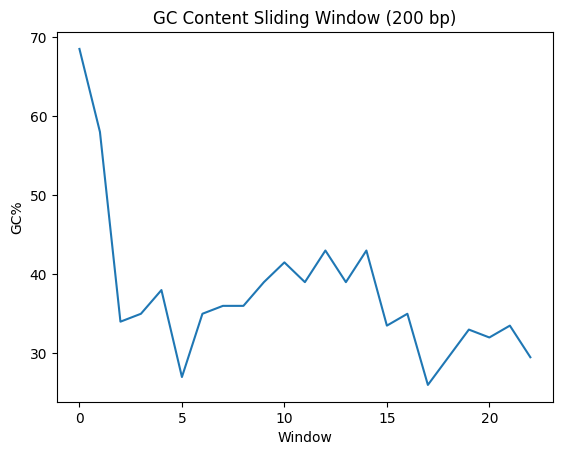

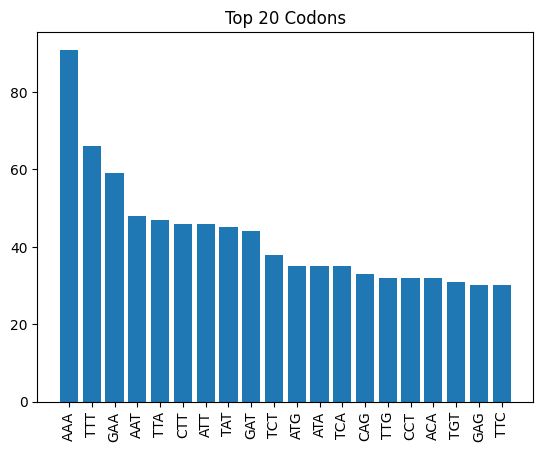

In [ ]:
# -----------------------------
# Block 7: Visualization
# -----------------------------
# GC sliding plot
gc_values = [SeqUtils.gc_fraction(nucl_record.seq[i:i+200])*100 for i in range(0,len(nucl_record.seq)-200,200)]
plt.plot(gc_values)
plt.title("GC Content Sliding Window (200 bp)")
plt.ylabel("GC%")
plt.xlabel("Window")
plt.savefig(OUTDIR / "gc_plot.png")
plt.show()
# Codon usage plot
codon_items = codon_counts.most_common(20)
labels, values = zip(*codon_items)
plt.bar(labels, values)
plt.xticks(rotation=90)
plt.title("Top 20 Codons")
plt.savefig(OUTDIR / "codon_usage.png")



In [16]:
from Bio import Entrez, SeqIO
from Bio.Blast import NCBIWWW, NCBIXML

# Always tell NCBI who you are
Entrez.email = "rashimakharia21@gmail.com"

# Step 1: Fetch NM_000321 record in GenBank format
print("Fetching NM_000321 from NCBI...")
handle = Entrez.efetch(db="nucleotide", id="NM_000321", rettype="gb", retmode="text")
record = SeqIO.read(handle, "genbank")
handle.close()

# Step 2: Extract CDS protein translation
protein_seq = None
for feature in record.features:
    if feature.type == "CDS" and "translation" in feature.qualifiers:
        protein_seq = feature.qualifiers["translation"][0]
        break

if not protein_seq:
    raise ValueError("No CDS translation found in NM_000321 record!")

print(f"✅ Protein sequence extracted. Length = {len(protein_seq)} amino acids")

# Step 3: Run BLASTP
print("Running BLASTP... this may take a few minutes.")
result_handle = NCBIWWW.qblast("blastp", "nr", protein_seq)

# Step 4: Parse BLAST results
blast_record = NCBIXML.read(result_handle)

print("\nTop 5 BLAST Hits for NM_000321 translated protein:")
print("=" * 70)
for alignment in blast_record.alignments[:5]:
    hsp = alignment.hsps[0]
    identity_pct = 100 * hsp.identities / hsp.align_length
    print(f"Hit: {alignment.hit_def}")
    print(f" Accession: {alignment.accession}")
    print(f" Length: {alignment.length}")
    print(f" Identity: {hsp.identities}/{hsp.align_length} ({identity_pct:.2f}%)")
    print(f" E-value: {hsp.expect}")
    print("-" * 70)


Fetching NM_000321 from NCBI...
✅ Protein sequence extracted. Length = 928 amino acids
Running BLASTP... this may take a few minutes.

Top 5 BLAST Hits for NM_000321 translated protein:
Hit: retinoblastoma-associated protein isoform 1 [Homo sapiens] >ref|XP_003811470.1| retinoblastoma-associated protein isoform X1 [Pan paniscus] >sp|P06400.2| RecName: Full=Retinoblastoma-associated protein; AltName: Full=p105-Rb; AltName: Full=p110-RB1; AltName: Full=pRb; Short=Rb; AltName: Full=pp110 [Homo sapiens] >gb|ABM82490.1| retinoblastoma 1 (including osteosarcoma) [synthetic construct] >gb|AAA53483.1| retinoblastoma susceptibility protein [Homo sapiens] >gb|AAA53484.1| retinoblastoma susceptibility protein [Homo sapiens] >gb|AAA69806.1| retinoblastoma-associated protein [Homo sapiens] >gb|AAA69808.1| retinoblastoma suceptibility protein [Homo sapiens]
 Accession: NP_000312
 Length: 928
 Identity: 928/928 (100.00%)
 E-value: 0.0
------------------------------------------------------------------